# Whatchamacallit
by [crumb](https://twitter.com/aicrumb), V0.1

A wrapper around the Diffusers Stable Diffusion Pipeline

In [1]:
#@markdown `model_name` can either be a repo (for diffusers) or the repo/model.ckpt (wherever the model is). <br>
#@markdown it will automatically be converted to a diffusers pipeline for sampling. <br>
#@markdown check out https://huggingface.co/sd-dreambooth-library for specific models
import os
if not os.path.exists("installed.txt"):
    # !pip install transformers diffusers -q
    !pip install transformers -q
    !pip install git+https://github.com/huggingface/diffusers -q
    !sudo apt-get install git-lfs
    !pip install OmegaConf -q
    !curl https://raw.githubusercontent.com/huggingface/diffusers/039958eae55ff0700cfb42a7e72739575ab341f1/scripts/convert_original_stable_diffusion_to_diffusers.py > convert.py
    !cat "true" > installed.txt

from huggingface_hub import notebook_login
notebook_login()

model_name = "hakurei/waifu-diffusion" #@param {type:"string"}

## **setup**

In [2]:
#@title import libraries
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, StableDiffusionInpaintPipeline
from diffusers import LMSDiscreteScheduler, DDIMScheduler, KarrasVeScheduler, PNDMScheduler, DDPMScheduler
import torchvision.transforms.functional as f
from torch import nn
from IPython.display import display, Image, clear_output
from tqdm.auto import trange
from huggingface_hub import hf_hub_download
torch.backends.cudnn.benchmark = True

In [3]:
# @title convert model if it's just a ckpt file
if ".ckpt" in model_name:
    !rm -r output-model
    repo_id = '/'.join(model_name.split("/")[:2])
    filename = '/'.join(model_name.split("/")[2:])
    print(repo_id, filename)
    compvis_path = hf_hub_download(repo_id=repo_id, filename=filename)

    !python convert.py --checkpoint_path "$compvis_path" --dump_path "output-model"
    model_name = "output-model"
    clear_output(wait=False)
    print("Model converted and saved at", model_name)

In [4]:
#@title setup samplers / download models

beta_schedule = "scaled_linear" #@param ['scaled_linear', 'linear']
sampling_dtype = "fp16" #@param ['fp16', 'fp32', 'bf32']
dtype_map = {
    "fp16": torch.float16,
    "fp32": torch.float32,
    "bf16": torch.bfloat16
}

beta_start = 0.00085 #@param
beta_end = 0.012 #@param

lms = LMSDiscreteScheduler(
    beta_start=beta_start, 
    beta_end=beta_end, 
    beta_schedule=beta_schedule
)
ddim = DDIMScheduler(
    beta_start=beta_start,
    beta_end=beta_end,
    beta_schedule=beta_schedule
)
ddpm = DDPMScheduler( # tune these parameters for whatever reason, they do Not work
    beta_start=beta_start,
    beta_end=beta_end,
    beta_schedule=beta_schedule
)
pndm = PNDMScheduler(
    beta_start=beta_start,
    beta_end=beta_end,
    beta_schedule=beta_schedule
)

pipe = StableDiffusionPipeline.from_pretrained(
    model_name,
    torch_dtype=torch.float32,
    scheduler=lms,
)
pipe = pipe.to("cuda")
pipe.enable_attention_slicing()

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


## **load textual inversion**

In [5]:
#@title load textual-inversion concepts from 🤗 hub

#@markdown `load_full_concepts_library` if turned on will take a While, it loads every single stable diffusion concept on https://huggingface.co/sd-concepts-library <br>
#@markdown `specific_concepts` can be a list of strings, containing the ids of your concepts (from sd-concepts-library or your own repos, example `["sd-concepts-library/my-first-inversion", "sd-concepts-library/my-second-inversion"]` etc.)

from huggingface_hub import HfApi
!pip install wget -q
import wget
import os
import requests
from huggingface_hub import hf_hub_download
api = HfApi()
def load_learned_embed_in_clip(learned_embeds_path, text_encoder, tokenizer, token=None):
        loaded_learned_embeds = torch.load(learned_embeds_path, map_location="cpu")
        
        # separate token and the embeds
        trained_token = list(loaded_learned_embeds.keys())[0]
        embeds = loaded_learned_embeds[trained_token]

        # cast to dtype of text_encoder
        dtype = text_encoder.get_input_embeddings().weight.dtype
        embeds.to(dtype)

        # add the token in tokenizer
        token = token if token is not None else trained_token
        num_added_tokens = tokenizer.add_tokens(token)
        i = 1
        # while(num_added_tokens == 0):
        #     print(f"The tokenizer already contains the token {token}.")
        #     token = f"{token[:-1]}-{i}>"
        #     print(f"Attempting to add the token {token}.")
        #     num_added_tokens = tokenizer.add_tokens(token)
        #     i+=1
        
        # resize the token embeddings
        text_encoder.resize_token_embeddings(len(tokenizer))
        
        # get the id for the token and assign the embeds
        token_id = tokenizer.convert_tokens_to_ids(token)
        text_encoder.get_input_embeddings().weight.data[token_id] = embeds
        return token

specific_concepts = ["sd-concepts-library/cat-toy"] #@param

models = []
for model in specific_concepts:
    model_content = {}
    model_content["id"] = model
    embeds = (model, "learned_embeds.bin")
    embeds_file = hf_hub_download(embeds[0], embeds[1])
    
    token_identifier = (model, "token_identifier.txt")
    tokens_file = hf_hub_download(token_identifier[0], token_identifier[1])
    # print(f"added {token_name}")
    token_name = open(tokens_file, "r").read()
    print("adding", token_name)

    learned_token = load_learned_embed_in_clip(embeds_file, pipe.text_encoder, pipe.tokenizer, token_name)
    model_content["token"] = learned_token
    models.append(model_content)



adding <cat-toy>


In [6]:
#@title convert old embedding

#@markdown convert original textual-inversion embeds to huggingface-style ones <br> You can run this cell however many times is needed to input all of your inversions.

from IPython.display import FileLink
import torch

input_file = "" #@param {"type":"string"}
placeholder_token = "<my-style>" #@param {"type":"string"}

def convert_and_load(input_file, placeholder_token):
    x = torch.load(input_file, map_location=torch.device('cpu'))

    params_dict = {
        placeholder_token: torch.tensor(list(x['string_to_param'].items())[0][1])
    }
    torch.save(params_dict, "learned_embeds.bin")
    load_learned_embed_in_clip("learned_embeds.bin", pipe.text_encoder, pipe.tokenizer, placeholder_token)
    print("loaded", placeholder_token)

if input_file != "":
    convert_and_load(input_file, placeholder_token)

In [7]:
#@markdown load a few midjourney styles
import gdown
gdown.download_folder(url="https://drive.google.com/drive/u/9/folders/1whqzuBtiAIo9V12I20I1EVkfE9TLb1hS", quiet=True)

try:
    folder = "/content/midj textual inversion"
    files = [folder+"/"+i for i in os.listdir(folder) if ".pt" in i]
except: # WHY DOES IT SOMETIMES DO THIS AND SOMETIMES DO IT THE OTHER WAY????? IM SO ANGRY
    folder = "/content"
    files = [folder+"/"+i for i in os.listdir(folder) if ".pt" in i]
names = ["<"+i.split("/")[-1].split(".")[0]+">" for i in files]

for i,j in zip(files, names):
    convert_and_load(i,j)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


loaded <midj-anthro>
loaded <midj-strong>
loaded <midj-portrait>


## **other model tricks**

In [8]:

#@markdown inspired by novelai's approach, works *to an extent* with vanilla SD models
#@markdown recommended value = 0, idk it kinda sucks, play around with it
del_last_layers = 1 #@param

if del_last_layers > 0:
    for i in range(del_last_layers):
        # del pipe.text_encoder.text_model.encoder.layers[11]
        del pipe.text_encoder.text_model.encoder.layers[11-i]

## **generate**

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

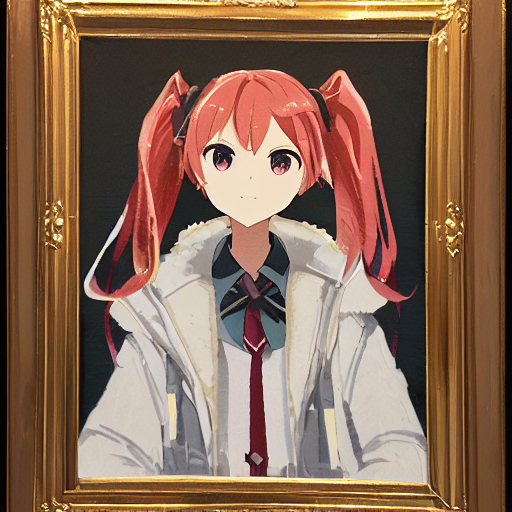

In [16]:
import PIL.Image as PImage

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = PImage.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

if not os.path.exists("output"):
    !mkdir output
prompt = "masterpiece, best quality, masterpiece, miku" #@param {type:"string"}
negative = "lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts,signature, watermark, username, blurry, artist name" #@param {type:"string"}

init_image_url = "" #@param {type:"string"}
init_strength = 0.0 #@param
strength = 1-init_strength

scheduler = "lms" #@param ['lms', 'ddim', 'pndm']

scheduler_map = {
    "lms": lms,
    "ddim": ddim, # someone please help get the right params for the ddim/ddpm samplers
    "ddpm": ddpm, # under maintanence
    "pndm": pndm,
    "default": pipe.scheduler # going to be useful later for clip guided sampling
}
pipe.scheduler = scheduler_map[scheduler]

steps = 75 #@param
# steps = steps - 9 # dude i have NO CLUE LOL
width_height = [512, 512] #@param
width, height = width_height
guidance_scale = 10 #@param
seed = 1 #@param
if seed == -1:
    import random
    seed = random.randint(1, 100_000)
    print("Using random seed:", seed)


batch_size = 1 #@param
batches = 1 #@param

# negative_prompt = None if len(negative)<=1 else [negative]*batch_size
# prompt = [prompt] * batch_size

negative_prompt = None if len(negative)<=1 else negative

# disable safety checker so that if something is accidentally tagged nsfw it doesn't matter
disable_safety_checker = True #@param {type:"boolean"}

if len(init_image_url)>1:
    import requests
    from io import BytesIO
    response = requests.get(init_image_url)
    init_image = PImage.open(BytesIO(response.content)).convert("RGB")
    init_image = init_image.resize((width, height))

    use_pipe = StableDiffusionImg2ImgPipeline(
        vae = pipe.vae,
        text_encoder = pipe.text_encoder,
        tokenizer = pipe.tokenizer,
        unet = pipe.unet,
        scheduler = pipe.scheduler,
        safety_checker = pipe.safety_checker,
        feature_extractor = pipe.feature_extractor
    )
    use_init = True
else:
    use_pipe = pipe
    use_init = False
with autocast("cuda"):
    if disable_safety_checker:
        # sometimes it's *really* bad and flags innocent fine images
        class DummyOutput(nn.Module):
            def __init__(self, pixel_values):
                super().__init__()
                self.hacking_into_the_mainframe = True
                self.pixel_values = nn.Parameter(pixel_values)
            def forward(self):
                return self.pixel_values

        class DummyFeatureExtractor:
            def __init__(self):
                self.mainframe = "HAAACCKKEDD"
            def __call__(self, x, **extra):
                pixel_values = f.to_tensor(x[0])
                return DummyOutput(pixel_values)

        class DummySafetyChecker:
            def __init__(self):
                self.hacker_code = "injected"
            def __call__(self, images, clip_input):
                return images, False

        use_pipe.feature_extractor = DummyFeatureExtractor()
        use_pipe.safety_checker = DummySafetyChecker()
    for i in trange(batches):
        generator = torch.cuda.manual_seed(seed+i)
        if use_init:
            image = use_pipe(prompt, num_images_per_prompt=batch_size, negative_prompt=negative_prompt, width=width, height=height, guidance_scale=guidance_scale, generator=generator, num_inference_steps=steps,
                         init_image=init_image, strength=strength).images  
        else:
            image = use_pipe(prompt, num_images_per_prompt=batch_size, negative_prompt=negative_prompt, width=width, height=height, guidance_scale=guidance_scale, generator=generator, num_inference_steps=steps).images  
        filename = "output/" + str(i).rjust(5, "0") + ".png"
        image = image_grid(image, 1, batch_size)
        image.save(filename)
        display(Image(filename))
        from google.colab import output
        output.eval_js('new Audio("https://freesound.org/data/previews/80/80921_1022651-lq.ogg").play()')